In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import grid_search
from scipy.integrate import trapz
from sklearn.preprocessing import StandardScaler
import collections

%matplotlib nbagg
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def roc(pr, Yt, true_class=0):
    """
    Produce the false positive rate and true positive rate required to plot
    a ROC curve, and the area under that curve.

    Parameters
    ----------
    pr : array
        An array of probability scores, either a 1d array of size N_samples or an nd array,
        in which case the column corresponding to the true class will be used.
    Yt : array
        An array of class labels, of size (N_samples,)
    true_class : int
        which class is taken to be the "true class" (e.g. Ia vs everything else)

    Returns
    -------
    fpr : array
        An array containing the false positive rate at each probability threshold
    tpr : array
        An array containing the true positive rate at each probability threshold
    auc : float
        The area under the ROC curve

    """
    probs = pr.copy()
    Y_test = Yt.copy()
    min_class = (int)(Y_test.min())  # This is to deal with starting class assignment at 1.
    Y_test = Y_test.squeeze()
    
    if len(pr.shape)>1:
        probs_1 = probs[:, true_class-min_class]
    else:
        probs_1 = probs
    
    threshold = np.linspace(0., 1., 50)  # 50 evenly spaced numbers between 0,1

    # This creates an array where each column is the prediction for each threshold
    preds = np.tile(probs_1, (len(threshold), 1)).T >= np.tile(threshold, (len(probs_1), 1))
    Y_bool = (Y_test == true_class)
    Y_bool = np.tile(Y_bool, (len(threshold), 1)).T
    
    TP = (preds & Y_bool).sum(axis=0)
    FP = (preds & ~Y_bool).sum(axis=0)
    TN = (~preds & ~Y_bool).sum(axis=0)
    FN = (~preds & Y_bool).sum(axis=0)
    
    tpr = np.zeros(len(TP))
    tpr[TP != 0] = TP[TP != 0]/(TP[TP != 0] + FN[TP != 0])
    fpr = FP/(FP+TN)
    
    fpr = np.array(fpr)[::-1]
    tpr = np.array(tpr)[::-1]
    
    auc = trapz(tpr, fpr)

    return fpr, tpr, auc

def plot_roc(fpr, tpr, auc, labels=[], cols=[],  label_size=26, tick_size=18, line_width=3):
    """
    Plots a ROC curve or multiple curves. Can plot the results from multiple classifiers if fpr and tpr are arrays
    where each column corresponds to a different classifier.

    Parameters
    ----------
    fpr : array
        An array containing the false positive rate at each probability threshold
    tpr : array
        An array containing the true positive rate at each probability threshold
    auc : float
        The area under the ROC curve
    labels : list, optional
        Labels of each curve (e.g. ML algorithm names)
    cols : list, optional
        Colors of the line(s)
    label_size : float, optional
        Size of x and y axis labels.
    tick_size: float, optional
        Size of tick labels.
    line_width : float, optional
        Line width
    """

    #Automatically fill in the colors if not supplied
    if not isinstance(cols, str) and len(cols)==0:
        cols=['#185aa9','#008c48','#ee2e2f','#f47d23','#662c91','#a21d21','#b43894','#010202']

    
    #This should work regardless of whether it's one or many roc curves
    #fig=plt.figure(figsize=figsize)
    fig=plt.gcf()
    ax=fig.add_subplot(111)
    ax.set_color_cycle(cols)
    ax.plot(fpr, tpr, lw=line_width)
    # ax.plot(fpr, tpr)
    
    ax.tick_params(axis='both', which='major', labelsize=tick_size)

    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    plt.xlabel('False positive rate (contamination)', fontsize=label_size)
    plt.ylabel('True positive rate (completeness)', fontsize=label_size)
#     plt.xlabel('False positive rate (contamination)')
#     plt.ylabel('True positive rate (completeness)')
    
    #Robust against the possibility of AUC being a single number instead of list
    if not isinstance(auc, collections.Sequence):
        auc=[auc]
    
    if len(labels)>0:
        labs=[]
        for i in range(len(labels)):
            labs.append(labels[i]+' (%.3f)' %(auc[i]))
    else:
        labs=np.array(range(len(ax.lines)), dtype='str')
        for i in range(len(labs)):
            labs[i]=(labs[i]+' (%.3f)' %(auc[i]))
    #plt.legend(labs, loc='lower right',  fancybox=True, bbox_to_anchor=(0.95, 0.05), fontsize=label_size)
    plt.legend(labs, loc='lower right',  bbox_to_anchor=(0.95, 0.05))
    plt.tight_layout()
    
def __custom_auc_score(estimator, X, Y):
    """
    Custom scoring method for use with GridSearchCV.

    Parameters
    ----------
    estimator : sklearn.Classifier
        The current classifier (used by GridSearchCV).
    X : array
        Array of training features of shape (n_train,n_features).
    Y : array
        Array of known classes of shape (n_train)

    Returns
    -------
    auc : float
        AUC score

    """
    probs=estimator.predict_proba(X)
    fpr, tpr, auc=roc(probs, Y, true_class=1)
    return auc

In [3]:
feats = np.load('training_density_ellipticity_features.npy')

In [4]:
feats.shape

(50000, 101)

I'm going to assume features up to 50 are density, the rest are ellipticity, the last column is in/out

In [71]:
X = feats[:, :-1]
y = feats[:, -1]
y[y==-1] = 0

In [73]:
Xorig = X
scal = StandardScaler()
scal.fit(X)

Xnew = scal.transform(X)
X = Xnew

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
fpr_all, tpr_all, auc_all = roc(probs, y_test, true_class=1)
importance_all = clf.feature_importances_
clf_all = clf
print(auc_all)

0.886612548787


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X[:,:50], y, test_size=0.33)
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
fpr_dens, tpr_dens, auc_dens = roc(probs, y_test, true_class=1)
importance_dens = clf.feature_importances_
clf_dens = clf
print(auc_dens)

0.870482615725


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X[:,50:], y, test_size=0.33)
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
fpr_ell, tpr_ell, auc_ell = roc(probs, y_test, true_class=1)
importance_ell = clf.feature_importances_
clf_ell = clf
print(auc_ell)

0.868178349926


<IPython.core.display.Javascript object>


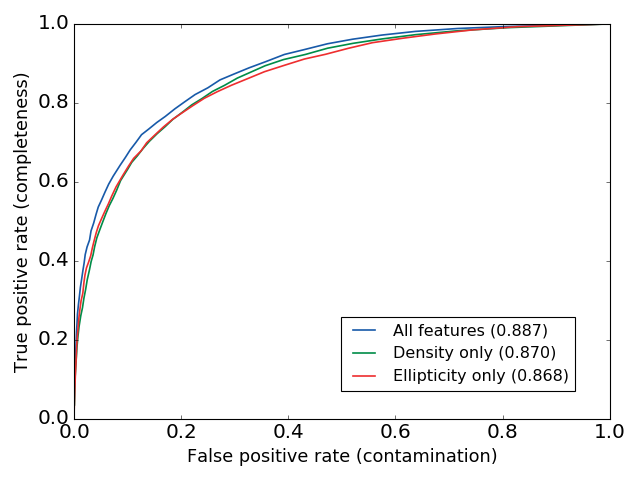

/home/michelle/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [63]:
FPR = np.column_stack((fpr_all, fpr_dens, fpr_ell))
TPR = np.column_stack((tpr_all, tpr_dens, tpr_ell))
AUC = [auc_all, auc_dens, auc_ell]
plt.figure()
plot_roc(FPR, TPR, AUC, labels=['All features', 'Density only', 'Ellipticity only'], label_size=16, line_width=1.5)

<IPython.core.display.Javascript object>


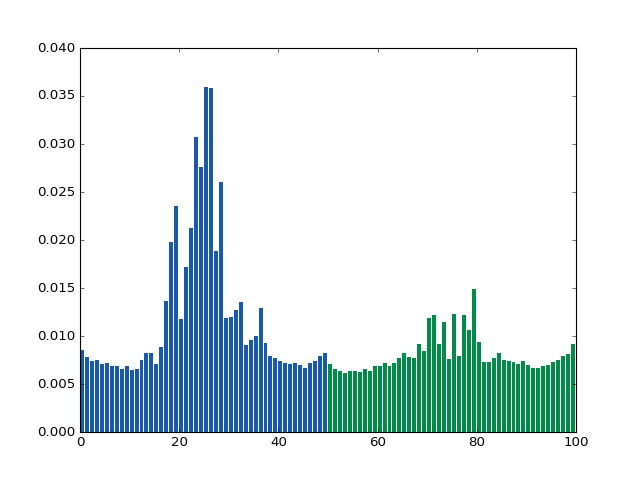

<Container object of 50 artists>

In [64]:
plt.figure()
plt.bar(np.arange(0,len(importance_all)/2), importance_all[:50], facecolor='#185aa9', edgecolor='none')
plt.bar(np.arange(len(importance_all)/2, len(importance_all)), importance_all[50:], facecolor='#008c48', edgecolor='none')

<IPython.core.display.Javascript object>


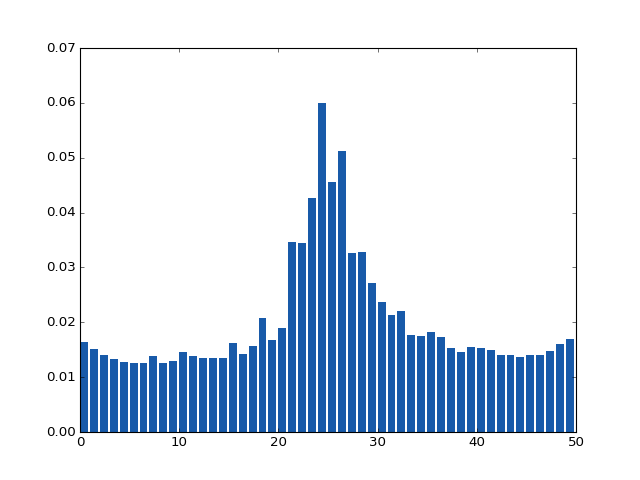

<Container object of 50 artists>

In [65]:
plt.figure()
plt.bar(np.arange(len(importance_dens)), importance_dens, facecolor='#185aa9', edgecolor='none')

<IPython.core.display.Javascript object>


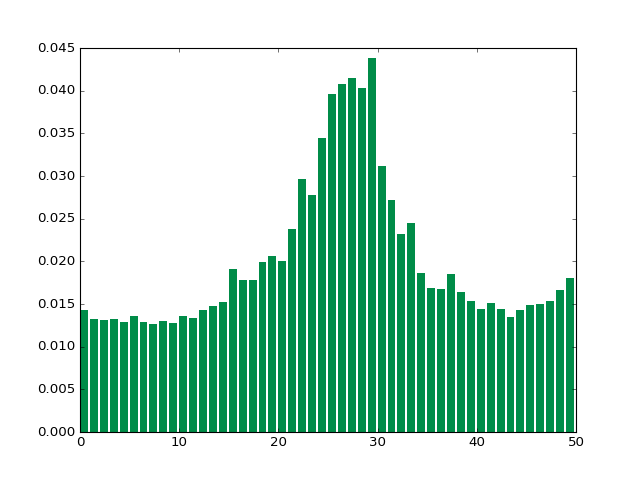

<Container object of 50 artists>

In [66]:
plt.figure()
plt.bar(np.arange(len(importance_ell)), importance_ell, facecolor='#008c48', edgecolor='none')

<IPython.core.display.Javascript object>


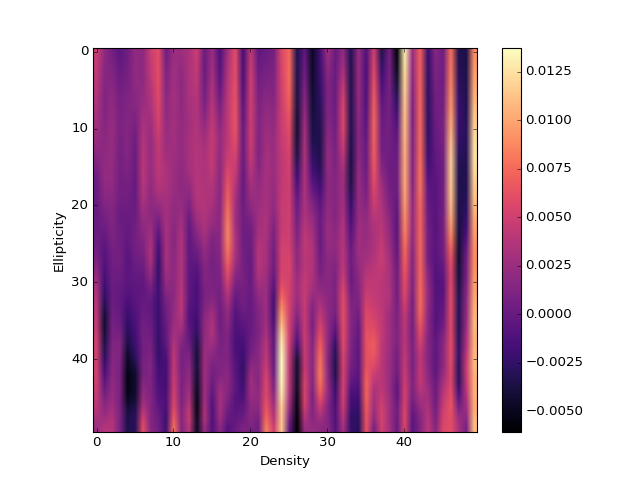

In [80]:
plt.figure()
corr = np.cov(Xnew.T) # Toggle between unscaled and scaled
c1 = corr[:50,50:]
plt.imshow(c1, cmap='magma')
plt.xlabel('Density')
plt.ylabel('Ellipticity')
plt.colorbar()

<IPython.core.display.Javascript object>


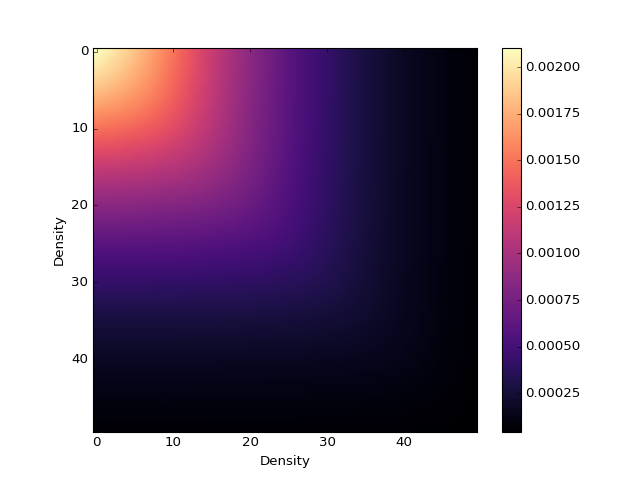

In [78]:
plt.figure()
c1 = corr[:50,:50]
plt.imshow(c1, cmap='magma')
plt.xlabel('Density')
plt.ylabel('Density')
plt.colorbar()

<IPython.core.display.Javascript object>


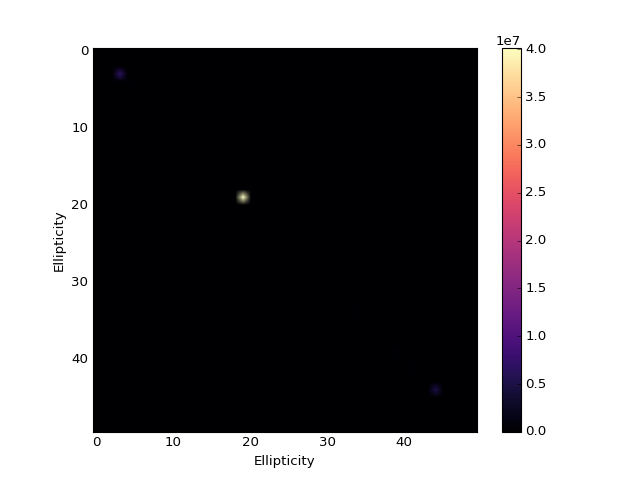

In [79]:
plt.figure()
c1 = corr[50:,50:]
#c1[np.arange(len(c1)), np.arange(len(c1))] = 0
plt.imshow(c1, cmap='magma')
plt.xlabel('Ellipticity')
plt.ylabel('Ellipticity')
plt.colorbar()

In [43]:
c1[np.arange(len(c1)), np.arange(len(c1))]

array([  1.14018485e+04,   7.88602203e+04,   2.40923862e+05,
         6.58700266e+06,   3.40326325e+05,   7.06681076e+04,
         4.85015077e+04,   2.43599904e+04,   8.92054633e+03,
         5.87515519e+04,   3.21884275e+04,   5.57473252e+04,
         2.78622811e+04,   1.93127533e+04,   2.37941962e+04,
         1.50263570e+04,   8.05805520e+04,   7.16978907e+03,
         2.19241946e+04,   4.01246366e+07,   6.35246200e+04,
         3.76347700e+04,   2.50599757e+04,   1.96463966e+05,
         1.23598386e+04,   1.09536011e+04,   8.98218112e+04,
         1.69186638e+04,   2.24226341e+04,   2.58960191e+05,
         9.51519565e+04,   2.38803057e+05,   8.32863447e+03,
         1.67869129e+05,   5.65410410e+05,   8.07019962e+03,
         8.40467512e+03,   1.50194691e+04,   3.95891248e+04,
         4.75142483e+05,   1.42097741e+04,   3.70963947e+05,
         1.47050121e+04,   5.82141965e+04,   5.09972719e+06,
         1.60950234e+04,   7.04331028e+03,   9.48725096e+04,
         1.24562364e+05,